<a href="https://colab.research.google.com/github/secutron/TesTime/blob/main/diffusers/01_guideline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 설명: [(diffusers) 기본 사용법 및 controlnet 모델 카드](https://blog.naver.com/secutron/223123353215)

In [1]:
!pip install -q diffusers transformers xformers git+https://github.com/huggingface/accelerate.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.9/934.9 kB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 108.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.1/109.1 MB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 102.5 MB/s eta 0:00:00


Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

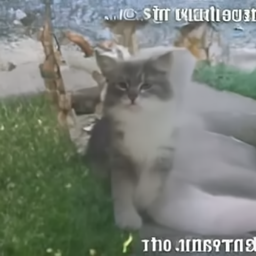

In [2]:
from diffusers import DDPMPipeline

ddpm = DDPMPipeline.from_pretrained("google/ddpm-cat-256").to("cuda")
image = ddpm(num_inference_steps=25).images[0]
image

256


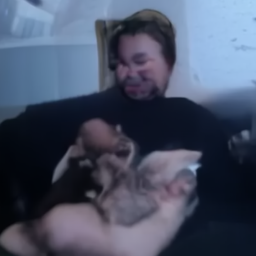

In [3]:
import numpy as np
import torch
from PIL import Image
from diffusers import DDPMScheduler, UNet2DModel

def pred_to_iamge(pred):
    image = (pred / 2 + 0.5).clamp(0, 1)
    image = image.cpu().permute(0, 2, 3, 1).numpy()[0]
    image = Image.fromarray((image * 255).round().astype("uint8"))
    return image

scheduler = DDPMScheduler.from_pretrained("google/ddpm-cat-256")
model = UNet2DModel.from_pretrained("google/ddpm-cat-256").to("cuda")

scheduler.set_timesteps(50)

sample_size = model.config.sample_size
print(sample_size)
noise = torch.randn((1, 3, sample_size, sample_size)).to("cuda")

input = noise

for t in scheduler.timesteps:
    with torch.no_grad():
        noisy_residual = model(input, t).sample

    previous_noisy_sample = scheduler.step(noisy_residual, t, input).prev_sample
    input = previous_noisy_sample

image = pred_to_iamge(input)
image